## Bayesian Linear Regression

In this notebook I will reproduce the figures from Section 3.3.1 of Bishop's [Pattern Recognition and Machine Learning](http://www.springer.com/us/book/9780387310732).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

## Description:

In this notebook, we investigate a Bayesian approach to regression. 

We will collect noisy data of the form $(x_i,y_i)$ where the $y_i$ are noisy measurements of a linear model with the following form:

$$y(x,w) = w_0 + w_1 \cdot x$$

The noise model is i.i.d. Gaussian with the form $\mathcal{N}(0,\beta^2)$.

**Note** As a short hand, I'll refer to the parameter $w$ as a linear weight. Also, I ignore Bishop's convention for the target values, and use $y$ in place of $t$.

In [2]:
def y_w(x, w):
    return w[0] + w[1] * x

def noisy_data(x, a, beta):
    y = y_w(x, a)

    try:
        return y + np.random.normal(0, 1.0/np.sqrt(beta), len(x))
    except:
        return y + np.random.normal(0, 1.0/np.sqrt(beta))        

The true model has the linear weight $w = (-0.3,0.5)$, i.e. an intercept of $-0.3$ and slope of $0.5$. We assume that the noise precision parameter is $\beta = 25$.

In [3]:
# true linear weight:
w_true = np.array([-0.3,0.5])

# set seed for reproducibility:
np.random.seed(1)

# generate random (x,y(x,a)):
xs = np.random.uniform(-1.0, 1.0, 1000)
beta = 25.0
ys = noisy_data(xs, w_true, beta)

A plot of the true model (in red) along with the data samples.

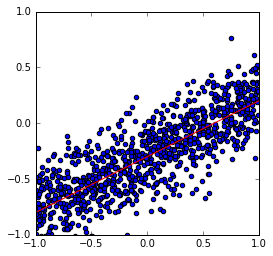

In [4]:
# true line:
x_plot = np.linspace(-1.0, 1.0, 10)
y_plot = w_true[0] + w_true[1] * x_plot

# plot the true line and the data:
plt.scatter(xs, ys)
plt.plot(x_plot, y_plot, c='r')
plt.axis([-1, 1, -1, 1])
plt.axes().set_aspect('equal')

### Prior model:

Initially we assume a zero mean isotropic Gaussian prior on the linear weights $w$. That is, our prior on the linear weights is:

$$p(w | \alpha) = \mathcal{N}(0, \alpha^{-1} I).$$

Where the parameter $\alpha > 0$. In Chapter 3 of Bishop's book, he doesn't explain how you would go about choosing $\alpha$, so we just guess $\alpha = 2.0$ for now.

In [5]:
alpha = 2.0

## Posterior distribution:
Under the noise model described above, and with the prior distribution above, it can be shown that when  $N$ data points have been observed, the posterior distribution is given by:

$$p(w|y) = \mathcal{N}(w | m_N, S_N). $$

Where

$$m_N = \beta S_N \Phi^T I,$$

and 

$$ S_N^{-1} = \alpha I + \beta \Phi^T \Phi.$$

In [6]:
# RV of posterior distribution on weights:
def ws_posterior_rv(N, xs = xs, ys = ys, alpha=alpha, beta=beta):
    # feature transformation:
    Phi = np.array([[1, x] for x in xs[:N]])
    
    # inverse covariance of posterior distribution:
    SNinv = alpha * np.eye(2) + beta * np.dot(Phi.T, Phi)
    SN = np.linalg.inv(SNinv)
    
    # mean of posterior distribution:
    if N > 0:
        mN = beta * np.dot(SN, np.dot(Phi.T, ys[:N]))
    else:
        mN = np.array([0,0])
        
    return multivariate_normal(mN,SN)

## Plotting function for the examples below:

In [7]:
def plot_posteriors(N, xs = xs, ys = ys, N_ws = 6):
    w_posterior = ws_posterior_rv(N, xs, ys)
    ws = w_posterior.rvs(N_ws)
    
    nx = 100
    ny = 100 
    xg = np.linspace(-1,1,nx)
    yg = np.linspace(-1,1,ny)
    ps = np.array([[x,y] for x in xg for y in yg])
    
    xg = ps[:,0].reshape((nx,ny))
    yg = ps[:,1].reshape((nx,ny))
    zg = w_posterior.pdf(ps).reshape((nx,ny))
    
    fig, (ax0,ax1) = plt.subplots(1, 2)
    fig.set_size_inches(8,4)
    ax0.imshow(zg.T, interpolation='bilinear', origin='lower', 
               cmap=cm.coolwarm, extent=(-1, 1, -1, 1))
    ax0.scatter(w_true[0], w_true[1], c='black', marker='+', 
                s=100, linewidths=2.0)
    ax0.axis([-1,1,-1,1])
    ax0.set_xlabel(r'$w_0$', fontsize=14)
    ax0.set_ylabel(r'$w_1$', fontsize=14)        
    ax0.set_aspect('equal')
    ax0.set_title('Posterior distribution, n = {0} data points'.format(N), y = 1.08)
    
    ax1.scatter(xs[:N],ys[:N])
    for i in range(N_ws):
        y_plot = y_w(x_plot, ws[i,:])
        ax1.plot(x_plot, y_plot, c='r')
    ax1.axis([-1,1,-1,1])
    ax1.set_xlabel(r'$x$', fontsize=14)
    ax1.set_ylabel(r'$y$', fontsize=14)
    ax1.set_title('Lines sampled from posterior distribution'.format(N), y =1.08)    
    ax1.set_aspect('equal')
        
    #fig.subplots_adjust(hspace=-1)
    plt.tight_layout()
    return fig

## Plots:
- On the left is a plot of the posterior distribution when we have observed $n = 0,1,2,20$ data points.
- We plot the true weight as a black cross on top of the posterior distribution.
- On the right is a plot of $6$ lines generated from sampling linear weights from the posterior distribution.
- We plot the observed data points along with the sampled lines.

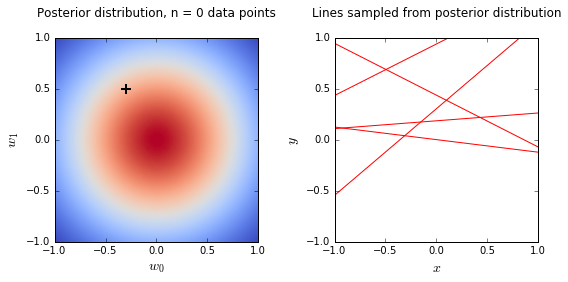

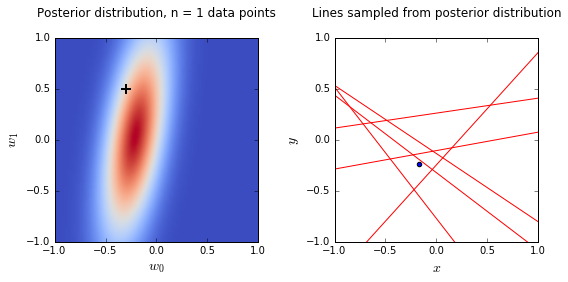

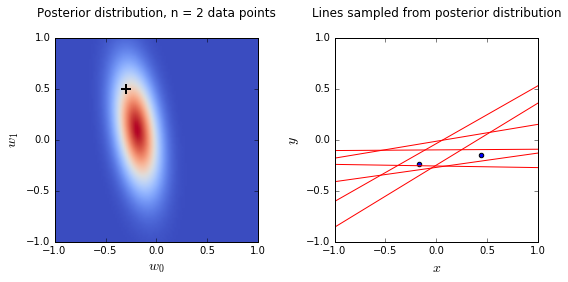

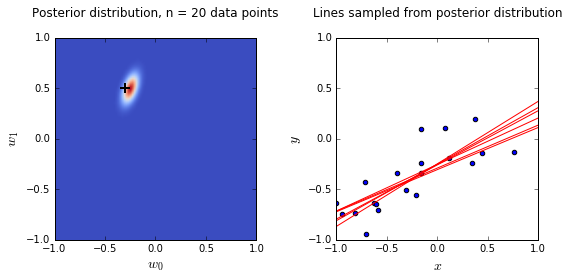

In [8]:
# set seed for reproducibility:
np.random.seed(10)

# generate analogous plots to Bishop Chapter 3:
for i in [0,1,2,20]:
    plot_posteriors(i)

Generate png images for $N = 0,1,\ldots,99$ so I can make a `gif` image later.

In [9]:
%%capture
import os
try:
    os.mkdir('./imgs')
except:
    pass

# set seed for reproducibility:
np.random.seed(33)

# plot the images:
for i in range(0,100):
    fig = plot_posteriors(i, xs, ys)
    fig.savefig('./imgs/test_{0:03}.png'.format(i))
    fig.clf()

## A `gif` demonstrating the process:

Here's that `gif` that I made "later." 

What's going on here?:
- we see that as the number of observationsn grows, the posterior distribution gets more confident about the solution and  tends towards a delta centered approximately on the correct linear weight
- as a result, the lines sampled from the posterior distribution are converging toward a single line (with the approximately correct weight) as the number of observations gets large.

<img src="./imgs/output.gif", width=500>

Let's note that this *wouldn't* be the case if we used a wildly bad choice for $\alpha$. In fact, $\alpha$ works as a regularizing parameter, and choosing too large a value for $\alpha$ will bias the solution. (Essentially, Bishop gave us a decent $\alpha$).